<small>This notebook was put together by [wesley beckner](http://wesleybeckner.github.io)</small>

<a id='top'></a>

# Contents

[scrape heat capacity data](#cpscrape)

[create descriptors](#descriptors)

[scrape density data](#densscrape)

[scrape viscosity data](#viscscrape)

In [1]:
#import gains as genetic
from math import inf
import statistics
import dill
import csv
import requests
import json
import pickle
import salty
import numpy as np
from numpy import array, all
import matplotlib.pyplot as plt
import numpy.linalg as LINA
from scipy import stats
from scipy.stats import uniform as sp_rand
from scipy.stats import mode
from sklearn.linear_model import Lasso

from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
import os
import sys
import pandas as pd
from collections import OrderedDict
from numpy.random import randint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from math import log
from time import sleep
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]   

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)  

In [166]:
def drop_rows_with_less_than_three_data_columns(df):
    to_drop = []
    for i in range(df.shape[0]):
        if df.iloc[i].isnull().sum() > 64: #entries with a gas phase do not include pressure. all other entires have 64 nan
            to_drop.append(i)
    df = df.drop(to_drop)
    df.reset_index(inplace = True, drop = True)
    print("number of droped entries: {}".format(len(to_drop)))
    return df

<a id='cpscrape'></a>

# Scrape Heat Capacity Data

[back to top](#top)

ILThermo has specific 4-letter tags for the properties in the database. These can be determined by inspecting the web elements on their website.

Melting point: prp=lcRG (note this in the paper_url string)

All that needs to be changed to scrape other property data is the 4-letter tag and the directory in which to save the information.

In [22]:
paper_url = "http://ilthermo.boulder.nist.gov/ILT2/ilsearch?"\
    "cmp=&ncmp=2&year=&auth=&keyw=&prp=tYhZ"
#the property codes can usually be found by opening the inspection
#console and searching for "dijit dijitReset dijitInline dijitLeft 
#dijitDownArrowButton dijitSelect dijitValidationTextBox" 
#and looking at the input value  

#thermal conductivity: VvTh bad
#electrical conductivity: bqdZ bad
#viscosity: AJfy
#melting temp: lcRG bad
#heat capacity: tYhZ
#density: VehR

    
r = requests.get(paper_url)
print(r)
#header = r.json()['header']
papers = r.json()['res']
print(len(papers))
i = 1
data_url = 'http://ilthermo.boulder.nist.gov/ILT2/ilset?set={paper_id}'
# print(papers)
for paper in papers[:]:
    
    r = requests.get(data_url.format(paper_id=paper[0]))
    data = r.json()['data']
    with open("../development/json/%s.json" % i, "w") as outfile:
        json.dump(r.json(), outfile)
    #then do whatever you want to data like writing to a file
    sleep(0.5) #import step to avoid getting banned by server
    i += 1

<Response [200]>
125


In [21]:
import requests
from time import sleep

def il_scrape(prp, ncmp=1):
    """
    webscraper tool for accessing backend data in the ILThermo
    browser. A few property codes are listed below, additional
    property codes can usually be found by opening the inspection
    console in your web brwoser and searching for "dijit dijitReset
    dijitInline dijitLeft dijitDownArrowButton dijitSelect
    dijitValidationTextBox" and looking at the input value in the html

    Paremeters
    ----------
    prp : str
        property ID. Current options are:
        thermal conductivity: VvTh
        electrical conductivity: bqdZ
        viscosity: blXM
        melting temp: lcRG
        heat capacity: bvSs
    ncmp : int
        number of components in IL. Default 1

    Returns
    -------
    data : json structure
    """


    paper_url = "http://ilthermo.boulder.nist.gov/ILT2/ilsearch?" \
                "cmp=&ncmp={}&year=&auth=&keyw=&prp={}".format(ncmp, prp)

    r = requests.get(paper_url)
    papers = r.json()['res']
    i = 1
    data_url = 'http://ilthermo.boulder.nist.gov/ILT2/ilset?set={paper_id}'
    data = []
    for paper in papers[:]:
        r = requests.get(data_url.format(paper_id=paper[0]))
        data.append(r)
        sleep(0.5)  # import step to avoid getting banned by server
        i += 1
    return data

In [24]:
il_scrape('AJfy')

[<Response [200]>, <Response [200]>]

In [9]:
ncmp='1'
prp='VvTh'

paper_url = "http://ilthermo.boulder.nist.gov/ILT2/ilsearch?" \
            "cmp=&ncmp={}&year=&auth=&keyw=&prp={}".format(ncmp, prp)

r = requests.get(paper_url)
papers = r.json()['res']
i = 1
data_url = 'http://ilthermo.boulder.nist.gov/ILT2/ilset?set={paper_id}'
data = []
for paper in papers[:]:
    r = requests.get(data_url.format(paper_id=paper[0]))
    print(r)
    data.append(r)
    sleep(0.5)  # import step to avoid getting banned by server
    i += 1


<a id='descriptors'></a>

# Create Descriptors

[back to top](#top)

The scraped data is in the form of a json file. The json files contain all the experimental information NIST has archived, including methods and experimental error!

Unfortunately the IUPAC names in the database are imperfect. We address this after the following cell.

In [749]:
###add JSON files to density.csv
outer_old = pd.DataFrame()
outer_new = pd.DataFrame()
number_of_files = 125 #set manually or use ipython magic to list dir
                      #contents
skipped = 0
unknown_solvent_type = 0
for i in range(number_of_files):
    with open("../development/cpt/%s.json" % str(i+1)) as json_file:

        #grab data, data headers (names), the salt name
        found_solute = False
        referenced_heat_capacity = False
        json_full = json.load(json_file)
        json_data = pd.DataFrame(json_full['data'])
        json_datanames = np.array(json_full['dhead'])
        json_data.columns =  json_datanames
        json_saltname = pd.DataFrame(json_full['components'])
        if json_full['phases'] != ["Liquid"]:
            print("skipping entry {} with the non liquid phases: {}".format(i+1,json_full['phases']))
            continue
        inner_old = pd.DataFrame()
        inner_new = pd.DataFrame()

        #loop through the columns of the data, note that some of the 
        #json files are missing pressure data. 
        if (len(json_data.columns.values) > 4) | (len(json_data.columns.values) < 4):
            print("entry {} has unexpected columns: {}".format(i+1,json_data.columns.values))
        for indexer in range(len(json_data.columns)):
            grab=json_data.columns[indexer]
            if '*' in grab[0]:
                skipped += 1
                referenced_heat_capacity = True
            if 'Heat' in grab[0]:
                if 'mol' in grab[0]:
                    measurement_key = grab[0]
                else:
                    skipped += 1
                    referenced_heat_capacity = True
#             if 'MolaLity' in grab[0]:
#                 if json_full['components'][0]['name'] in grab[0]:
#                     solute_key, solvent_key = 0, 1
#                 elif json_full['components'][1]['name'] in grab[0]:
#                     solute_key, solvent_key = 1, 0
#                 mol_frac_conversion = float(json_full['components'][solvent_key]['mw'])/1000 #g/mol to kg/mol
#                 mixture_col = grab[0]
#                 found_solute = True
            elif 'Mole' in grab[0]:
                if json_full['components'][0]['name'] in grab[0]:
                    #
                    solute_key, solvent_key = 0, 1
                    if len(json_saltname.iloc[solute_key][3].split(" ")) == 1:
                        # solute is the non il
                        solute_is_il = False
                        non_il = json_saltname.iloc[solute_key][3]
                        il = json_saltname.iloc[solvent_key][3]
                    elif len(json_saltname.iloc[solvent_key][3].split(" ")) == 1:
                        # solute is the il
                        solute_is_il = True
                        il = json_saltname.iloc[solute_key][3]
                        non_il = json_saltname.iloc[solvent_key][3]
                    else:
                        unknown_solvent_type += 1
                        continue
                elif json_full['components'][1]['name'] in grab[0]:
                    solute_key, solvent_key = 1, 0
                    if len(json_saltname.iloc[solute_key][3].split(" ")) == 1:
                        solute_is_il = False
                        non_il = json_saltname.iloc[solute_key][3]
                        il = json_saltname.iloc[solvent_key][3]
                    elif len(json_saltname.iloc[solvent_key][3].split(" ")) == 1:
                        solute_is_il = True
                        il = json_saltname.iloc[solute_key][3]
                        non_il = json_saltname.iloc[solvent_key][3]
                    else:
                        unknown_solvent_type += 1
                        continue
                mol_frac_conversion = 1 #already in mol fract
                mixture_col = grab[0]
                found_solute = True
#             elif 'Weight' in grab[0]:
#                 if json_full['components'][0]['name'] in grab[0]:
#                     solute_key, solvent_key = 0, 1
#                 elif json_full['components'][1]['name'] in grab[0]:
#                     solute_key, solvent_key = 1, 0
#                 mol_frac_conversion = float(json_full['components'][solvent_key]['mw'])/float(json_full['components'][solute_key]['mw'])
#                 mixture_col = grab[0]
# #                 found_solute = True
#             elif 'MolaRity' in grab[0]:
#                 if json_full['components'][0]['name'] in grab[0]:
#                     solute_key, solvent_key = 0, 1
#                 elif json_full['components'][1]['name'] in grab[0]:
#                     solute_key, solvent_key = 1, 0
#                 if json_full['components'][solvent_key]['name'] == 'water':
#                     mol_frac_conversion = float(json_full['components'][solvent_key]['mw'])/1000 #mol solute/Lwater to mol solute/mol W
#                 mixture_col = grab[0]
# #                 found_solute = True
                
            mlist = json_data[grab]
            #my_list grabs first element
            #change l[0] to l[1] for std
            my_list = [float(l[0]) for l in mlist] #drop exp std
            dfmy_list = pd.DataFrame(my_list)
            dfmy_list.columns = [json_datanames[indexer][0]]
            inner_new = pd.concat([dfmy_list, inner_old], axis=1)
            inner_old = inner_new
        if referenced_heat_capacity:
            print("skipping entry {} with non absolute heat capacity".format(i+1))
            continue
        if not found_solute:
            continue
        if found_solute:
            if solute_is_il:
                inner_old['mol fraction salt'] = inner_old[mixture_col]*mol_frac_conversion
            else:
                inner_old['mol fraction salt'] = 1-(inner_old[mixture_col]*mol_frac_conversion)
            #add the property value
#             inner_old['measurement'] = inner_old[measurement_key]
            #add the mol frac solute
            
            #add the name of the salt    
#             inner_old['first_component']=json_saltname.iloc[solute_key][3]          
#             inner_old['second_component']=json_saltname.iloc[solvent_key][3] 
            inner_old['salt'] = il
            inner_old['solvent'] = non_il
            #add to the growing dataframe
            outer_new = pd.concat([inner_old, outer_old], axis=0, sort=True)
            outer_old = outer_new
            continue     
        else:
            print("solute not found")
            break
cols = outer_old.columns
outer_old = outer_old[cols[::-1]]
pd.DataFrame.to_csv(outer_old, path_or_buf="../development/"\
    "cpt.csv", index=False)

skipping entry 2 with the non liquid phases: ['Crystal', 'Gas']
skipping entry 3 with non absolute heat capacity
skipping entry 6 with non absolute heat capacity
skipping entry 9 with non absolute heat capacity
skipping entry 11 with non absolute heat capacity
skipping entry 16 with non absolute heat capacity
skipping entry 17 with the non liquid phases: ['Liquid', 'Gas']
skipping entry 21 with the non liquid phases: ['Liquid', 'Gas']
skipping entry 59 with non absolute heat capacity
skipping entry 63 with the non liquid phases: ['Liquid', 'Gas']
skipping entry 74 with the non liquid phases: ['Glass']
skipping entry 80 with non absolute heat capacity
skipping entry 82 with non absolute heat capacity
skipping entry 83 with non absolute heat capacity
skipping entry 85 with non absolute heat capacity
skipping entry 86 with non absolute heat capacity
skipping entry 87 with non absolute heat capacity
skipping entry 89 with non absolute heat capacity
skipping entry 110 with non absolute heat

In [750]:
df = pd.read_csv('../development/cpt.csv',delimiter=',')
df.dropna(inplace=True, axis=1)
df.head()

,solvent,salt,mol fraction salt,"Temperature, K","Pressure, kPa","Heat capacity at constant pressure, J/K/mol"
0,water,1-butyl-3-methylimidazolium trifluoromethanesu...,0.9892,298.00,101.0,448.0
1,water,1-butyl-3-methylimidazolium trifluoromethanesu...,0.8630,298.00,101.0,401.0
2,water,1-butyl-3-methylimidazolium trifluoromethanesu...,0.6621,298.00,101.0,325.0
3,water,1-butyl-3-methylimidazolium trifluoromethanesu...,0.4785,298.00,101.0,257.0
4,water,pyrrolidinium nitrate,0.0000,298.15,101.3,75.3


In [751]:
df = pd.read_csv('../development/cpt.csv',delimiter=',')
df.dropna(inplace=True, axis=1)

to_drop = []
anions= []
cations= []
missed = 0
found = 0
non_ils = []
# 
# organize into cation, anion, solvent, mol frac IL

for i in range(df.shape[0]):
    il = df['salt'][i]
    non_il = df['solvent'][i]
    non_ils.append(non_il)
        
    if len(il.split()) == 2:
        cations.append(il.split()[0])
        anions.append(il.split()[1])
    elif len(il.split()) == 3:
        if("sulfate" in il or\
        "phosphate" in il or\
        "phosphonate" in il or\
        "carbonate" in il):
            #these strings have two-word anions
            first = il.split()[1]
            second = il.split()[2]
            cations.append(il.split()[0])
            anions.append(first + ' ' + second)
        elif("1:1" in salts["salts"].iloc[i]):
            #some strings contain the mixing ratio
            first = il.split()[0]
            second = il.split()[1]
            cations.append(first)
            anions.append(second)
        elif("(OC-6-11)-hexafluoroantimonate(1-)" in salts["salts"].iloc[i]):
            #special case
            cations.append("1-butyl-3-methylimidazolium")
            anions.append("hexafluoroantimonate")
        elif("1,3-propanediol, 2-amino-2-(hydroxymethyl)-," in salts["salts"].iloc[i]):
            #special case
            cations.append("2-amino-2-(hydroxymethyl)-1,3-propanediol")
            anions.append("hydrochloride")
        else:
            #assume the rest are two-word cations
            first = il.split()[0]
            second = il.split()[1]
            third = il.split()[2]
            cations.append(first + ' ' + second)
            anions.append(third)
    elif len(il.split()) == 4:
        #this particular string block contains (1:1) at end of name
        if("1,1,2,3,3,3-hexafluoro-1-propanesulfonate" in il):
            first = il.split()[0]
            second = il.split()[1]
            cations.append(first + ' ' + second)
            anions.append(il.split()[2])
        else:
            #and two word anion
            first = il.split()[1]
            second = il.split()[2]
            anions.append(first + ' ' + second)
            cations.append(il.split()[0])
    elif("2-aminoethanol-2-hydroxypropanoate" in il):
        #one of the ilthermo salts is missing a space between cation/anion
        anions.append("2-hydroxypropanoate")
        cations.append("2-aminoethanol")
    elif len(il.split()) == 5:
        if("bis[(trifluoromethyl)sulfonyl]imide" in il):
            anions.append("bis(trifluoromethylsulfonyl)imide")
            first = il.split()[0]
            second = il.split()[1]
            third = il.split()[2]
            fourth = il.split()[3]
            cations.append(first + ' ' + second + ' ' + third + ' ' + fourth)
        if("trifluoro(perfluoropropyl)borate" in il):
            anions.append("trifluoro(perfluoropropyl)borate")
            cations.append("N,N,N-triethyl-2-methoxyethan-1-aminium")
    elif("1H-imidazolium, 1-ethyl-3-methyl-, salt with trifluoroacetic acid (1:1)"
        in il):
        anions.append("trifluoroacetic acid")
        cations.append("1-ethyl-3-methyl-1H-imidazolium")
    elif("L-alanine, 1-methylethyl ester, dodecyl sulfate (1:1)"
        in il):
        anions.append("dodecyl sulfate")
        cations.append("L-alanine, 1-methylethyl ester")
    elif("difluorogermylene" in il):
        anions.append("difluoro")
        cations.append("germylene")
    else:
        print("uknown salt type:\t{}".format(il))
        df.drop(i, inplace=True)
        missed += 1
solvents = pd.DataFrame(non_ils, columns=['name-solvent'])
anions = pd.DataFrame(anions, columns=["name-anion"])
cations = pd.DataFrame(cations, columns=["name-cation"])
print("total missed solvents: {}".format(len(to_drop)))
print("total missed salts: {}".format(missed))
print("more salts may be missing from the cation/anion info files\n\
       check final dataframe dimensions after concatenating the\n\
       cation/anion descriptors")

total missed solvents: 0
total missed salts: 0
more salts may be missing from the cation/anion info files
       check final dataframe dimensions after concatenating the
       cation/anion descriptors


In [753]:
df.head()

,solvent,salt,mol fraction salt,"Temperature, K","Pressure, kPa","Heat capacity at constant pressure, J/K/mol"
0,water,1-butyl-3-methylimidazolium trifluoromethanesu...,0.9892,298.00,101.0,448.0
1,water,1-butyl-3-methylimidazolium trifluoromethanesu...,0.8630,298.00,101.0,401.0
2,water,1-butyl-3-methylimidazolium trifluoromethanesu...,0.6621,298.00,101.0,325.0
3,water,1-butyl-3-methylimidazolium trifluoromethanesu...,0.4785,298.00,101.0,257.0
4,water,pyrrolidinium nitrate,0.0000,298.15,101.3,75.3


In [754]:
from rdkit import Chem
from rdkit.ML.Descriptors.MoleculeDescriptors import\
    MolecularDescriptorCalculator as calculator


solvent_di = {'water': 'O',
              'urea': 'NC(N)=O',
              'ethanol': 'OCC',
              'methanol': 'OC',
              'glycerol': 'C(C(CO)O)O',
              '1,2-ethanediol': 'C(CO)O',
              'propan-1-ol': 'CCCO',
              'octan-1-ol': 'CCCCCCCCO',
              'acetonitrile': 'CC#N',
              'nitromethane': 'C[N+](=O)[O-]',
              'N-methylaniline': 'CNC1=CC=CC=C1',
              '2-methylaniline': 'CC1=CC=CC=C1N',
              'aniline': 'C1=CC=C(C=C1)N',
              'cyclopentanone': 'C1CCC(=O)C1',
              'cyclohexanone': 'C1CCC(=O)CC1',
              'pyridine': 'C1=CC=NC=C1',
              '2-pyrrolidinone': 'C1CC(=O)NC1',
              'N-methylpyrrolidone': 'CN1CCCC1=O',
              'bromobenzene': 'C1=CC=C(C=C1)Br',
              'butan-1-ol': 'CCCCO',
              'propan-2-ol': 'CC(C)O'
             }

old = pd.DataFrame()
deslist = salty.load_data("cationDescriptors.csv").columns[2:]
for index, item in enumerate(solvent_di):
    mol = Chem.MolFromSmiles(solvent_di[item])
    feature_vector = [item, solvent_di[item]]
    for desc in deslist:
        feature_vector.append(calculator([desc]).CalcDescriptors(mol)[0])
    new = pd.DataFrame(feature_vector).T
    new.columns = [str(i) + '-solvent' for i in salty.load_data("cationDescriptors.csv").columns]
    new = pd.concat([new, old], axis=0, sort=False)
    old = new
solventDescriptors = old

cationDescriptors = salty.load_data("cationDescriptors.csv")
cationDescriptors.columns = [str(col) + '-cation' for col in cationDescriptors.columns]
anionDescriptors = salty.load_data("anionDescriptors.csv")
anionDescriptors.columns = [str(col) + '-anion' for col in anionDescriptors.columns]

new_df = pd.concat([df, cations, anions, solvents], axis=1)
new_df = pd.merge(cationDescriptors, new_df, on="name-cation", how="right")
new_df = pd.merge(anionDescriptors, new_df, on="name-anion", how="right")
new_df = pd.merge(solventDescriptors, new_df, on="name-solvent", how="right")
new_df.dropna(inplace=True) #remove entries not in smiles database

In [755]:
new_df.head()

,name-solvent,smiles-solvent,steiger-solvent,Marsili Partial Charges-solvent,BalabanJ-solvent,BertzCT-solvent,Ipc-solvent,HallKierAlpha-solvent,Kappa1-solvent,Kappa2-solvent,Kappa3-solvent,Chi0-solvent,Chi1-solvent,Chi0n-solvent,Chi1n-solvent,Chi2n-solvent,Chi3n-solvent,Chi4n-solvent,Chi0v-solvent,Chi1v-solvent,Chi2v-solvent,Chi3v-solvent,Chi4v-solvent,MolLogP-solvent,MolMR-solvent,MolWt-solvent,HeavyAtomCount-solvent,HeavyAtomMolWt-solvent,NHOHCount-solvent,NOCount-solvent,NumHAcceptors-solvent,NumHDonors-solvent,NumHeteroatoms-solvent,NumRotatableBonds-solvent,NumValenceElectrons-solvent,RingCount-solvent,TPSA-solvent,LabuteASA-solvent,PEOE_VSA1-solvent,PEOE_VSA2-solvent,PEOE_VSA3-solvent,PEOE_VSA4-solvent,PEOE_VSA5-solvent,PEOE_VSA6-solvent,PEOE_VSA7-solvent,PEOE_VSA8-solvent,PEOE_VSA9-solvent,PEOE_VSA10-solvent,PEOE_VSA11-solvent,PEOE_VSA12-solvent,PEOE_VSA13-solvent,PEOE_VSA14-solvent,SMR_VSA1-solvent,SMR_VSA2-solvent,SMR_VSA3-solvent,SMR_VSA4-solvent,SMR_VSA5-solvent,SMR_VSA6-solvent,SMR_VSA7-solvent,SMR_VSA8-solvent,SMR_VSA9-solvent,SMR_VSA10-solvent,SlogP_VSA1-solvent,SlogP_VSA2-solvent,SlogP_VSA3-solvent,SlogP_VSA4-solvent,SlogP_VSA5-solvent,SlogP_VSA6-solvent,SlogP_VSA7-solvent,SlogP_VSA8-solvent,SlogP_VSA9-solvent,SlogP_VSA10-solvent,SlogP_VSA11-solvent,SlogP_VSA12-solvent,EState_VSA1-solvent,EState_VSA2-solvent,EState_VSA3-solvent,EState_VSA4-solvent,EState_VSA5-solvent,EState_VSA6-solvent,EState_VSA7-solvent,EState_VSA8-solvent,EState_VSA9-solvent,EState_VSA10-solvent,EState_VSA11-solvent,VSA_EState1-solvent,VSA_EState2-solvent,VSA_EState3-solvent,VSA_EState4-solvent,VSA_EState5-solvent,VSA_EState6-solvent,VSA_EState7-solvent,VSA_EState8-solvent,VSA_EState9-solvent,VSA_EState10-solvent,Topliss fragments-solvent,name-anion,smiles-anion,steiger-anion,Marsili Partial Charges-anion,BalabanJ-anion,BertzCT-anion,Ipc-anion,HallKierAlpha-anion,Kappa1-anion,Kappa2-anion,Kappa3-anion,Chi0-anion,Chi1-anion,Chi0n-anion,Chi1n-anion,Chi2n-anion,Chi3n-anion,Chi4n-anion,Chi0v-anion,Chi1v-anion,Chi2v-anion,Chi3v-anion,Chi4v-anion,MolLogP-anion,MolMR-anion,MolWt-anion,HeavyAtomCount-anion,HeavyAtomMolWt-anion,NHOHCount-anion,NOCount-anion,NumHAcceptors-anion,NumHDonors-anion,NumHeteroatoms-anion,NumRotatableBonds-anion,NumValenceElectrons-anion,RingCount-anion,TPSA-anion,LabuteASA-anion,PEOE_VSA1-anion,PEOE_VSA2-anion,PEOE_VSA3-anion,PEOE_VSA4-anion,PEOE_VSA5-anion,PEOE_VSA6-anion,PEOE_VSA7-anion,PEOE_VSA8-anion,PEOE_VSA9-anion,PEOE_VSA10-anion,PEOE_VSA11-anion,PEOE_VSA12-anion,PEOE_VSA13-anion,PEOE_VSA14-anion,SMR_VSA1-anion,SMR_VSA2-anion,SMR_VSA3-anion,SMR_VSA4-anion,SMR_VSA5-anion,SMR_VSA6-anion,SMR_VSA7-anion,SMR_VSA8-anion,SMR_VSA9-anion,SMR_VSA10-anion,SlogP_VSA1-anion,SlogP_VSA2-anion,SlogP_VSA3-anion,SlogP_VSA4-anion,SlogP_VSA5-anion,SlogP_VSA6-anion,SlogP_VSA7-anion,SlogP_VSA8-anion,SlogP_VSA9-anion,SlogP_VSA10-anion,SlogP_VSA11-anion,SlogP_VSA12-anion,EState_VSA1-anion,EState_VSA2-anion,EState_VSA3-anion,EState_VSA4-anion,EState_VSA5-anion,EState_VSA6-anion,EState_VSA7-anion,EState_VSA8-anion,EState_VSA9-anion,EState_VSA10-anion,EState_VSA11-anion,VSA_EState1-anion,VSA_EState2-anion,VSA_EState3-anion,VSA_EState4-anion,VSA_EState5-anion,VSA_EState6-anion,VSA_EState7-anion,VSA_EState8-anion,VSA_EState9-anion,VSA_EState10-anion,Topliss fragments-anion,name-cation,smiles-cation,steiger-cation,Marsili Partial Charges-cation,BalabanJ-cation,BertzCT-cation,Ipc-cation,HallKierAlpha-cation,Kappa1-cation,Kappa2-cation,Kappa3-cation,Chi0-cation,Chi1-cation,Chi0n-cation,Chi1n-cation,Chi2n-cation,Chi3n-cation,Chi4n-cation,Chi0v-cation,Chi1v-cation,Chi2v-cation,Chi3v-cation,Chi4v-cation,MolLogP-cation,MolMR-cation,MolWt-cation,HeavyAtomCount-cation,HeavyAtomMolWt-cation,NHOHCount-cation,NOCount-cation,NumHAcceptors-cation,NumHDonors-cation,NumHeteroatoms-cation,NumRotatableBonds-cation,NumValenceElectrons-cation,RingCount-cation,TPSA-cation,LabuteASA-cation,PEOE_VSA1-cation,PEOE_VSA2-cation,PEOE_VSA3-cation,PEOE_VSA4-cation,PEOE_VSA5-

In [756]:
pd.DataFrame.to_csv(new_df, path_or_buf='../development/'\
                    'mixture_heat_capacity_premodel.csv', index=False)

<a id='densscrape'></a>

# Scrape Density Data

[back to top](#top)

In [767]:
paper_url = "http://ilthermo.boulder.nist.gov/ILT2/ilsearch?"\
    "cmp=&ncmp=2&year=&auth=&keyw=&prp=VehR"
#the property codes can usually be found by opening the inspection
#console and searching for "dijit dijitReset dijitInline dijitLeft 
#dijitDownArrowButton dijitSelect dijitValidationTextBox" 
#and looking at the input value  

#thermal conductivity: VvTh bad
#electrical conductivity: bqdZ bad
#viscosity: AJfy
#melting temp: lcRG bad
#heat capacity: tYhZ
#density: VehR

    
r = requests.get(paper_url)
print(r)
#header = r.json()['header']
papers = r.json()['res']
print(len(papers))
i = 1951
data_url = 'http://ilthermo.boulder.nist.gov/ILT2/ilset?set={paper_id}'
# print(papers)
for paper in papers[1951:]:
    
    r = requests.get(data_url.format(paper_id=paper[0]))
    data = r.json()['data']
    with open("../development/density/%s.json" % i, "w") as outfile:
        json.dump(r.json(), outfile)
    #then do whatever you want to data like writing to a file
    sleep(0.5) #import step to avoid getting banned by server
    i += 1

<Response [200]>
2075


In [788]:
ls ../development/density/ | wc -l

    2074


In [886]:
df, skipped = json_to_csv('../development/density', 'Specific density, kg/m<SUP>3</SUP>', 'kg/m', 2074)

skipping entry 31 with referenced units: Specific density<SUP>*</SUP>, kg/m<SUP>3</SUP>
skipping entry 36 with the non liquid phases: ['Liquid', 'Gas']
skipping entry 39 with referenced units: Specific density<SUP>*</SUP>, kg/m<SUP>3</SUP>
skipping entry 50 with referenced units: Specific density<SUP>*</SUP>, kg/m<SUP>3</SUP>
entry 233 has unexpected columns: [('MolaLity of tetraphenylphosphorane bromide, mol/kg', 'Liquid')
 ('Temperature, K', None) ('Specific density, kg/m<SUP>3</SUP>', 'Liquid')]
skipping entry 308 with referenced units: Specific density<SUP>*</SUP>, kg/m<SUP>3</SUP>
skipping entry 324 with referenced units: Specific density<SUP>*</SUP>, kg/m<SUP>3</SUP>
skipping entry 359 with the non liquid phases: ['Liquid', 'Gas']
skipping entry 366 with the non liquid phases: ['Liquid mixture 1', 'Liquid of pure water']
skipping entry 483 with referenced units: Specific density<SUP>*</SUP>, kg/m<SUP>3</SUP>
skipping entry 528 with referenced units: Specific density<SUP>*</SUP>, 

In [887]:
print('total skipped data points: {}'.format(skipped))

total skipped data points: 31077


In [833]:
pd.DataFrame.to_csv(df, path_or_buf="../development/"\
    "density.csv", index=False)

In [880]:
df = pd.read_csv('../development/density.csv',delimiter=',')
df = df.loc[df['Specific density, kg/m<SUP>3</SUP>'].notnull()]
df.dropna(inplace=True, axis=1)
df.reset_index(inplace=True, drop=True)
df.head()

,solvent,salt,mol fraction salt,"Temperature, K","Specific density, kg/m<SUP>3</SUP>","Pressure, kPa"
0,decane,1-butyl-1-methylpyrrolidinium bis[(trifluorome...,0.977,298.15,1387.70,101.0
1,octane,1-butyl-1-methylpyrrolidinium bis[(trifluorome...,0.958,298.15,1384.10,101.0
2,benzene,1-butyl-1-methylpyrrolidinium dicyanamide,0.294,298.15,964.80,100.0
3,octane,1-butyl-1-methylpyrrolidinium dicyanamide,0.990,298.15,1012.40,100.0
4,cyclooctane,1-ethyl-3-methylimidazolium ethyl sulfate,0.988,298.15,1232.65,101.0


In [881]:
new_df = iupac_to_smiles(df)

uknown salt type:	1-butanaminium, N.N.N-tributyl-, salt with 2,4,6-trinitrophenol (1:1)
uknown salt type:	1-butanaminium, N.N.N-tributyl-, salt with 2,4,6-trinitrophenol (1:1)
uknown salt type:	1-butanaminium, N.N.N-tributyl-, salt with 2,4,6-trinitrophenol (1:1)
uknown salt type:	1-butanaminium, N.N.N-tributyl-, salt with 2,4,6-trinitrophenol (1:1)
uknown salt type:	1-butanaminium, N.N.N-tributyl-, salt with 2,4,6-trinitrophenol (1:1)
uknown salt type:	1-butanaminium, N.N.N-tributyl-, salt with 2,4,6-trinitrophenol (1:1)
uknown salt type:	1-butanaminium, N.N.N-tributyl-, salt with 2,4,6-trinitrophenol (1:1)
uknown salt type:	1-butanaminium, N.N.N-tributyl-, salt with 2,4,6-trinitrophenol (1:1)
uknown salt type:	1-butanaminium, N.N.N-tributyl-, salt with 2,4,6-trinitrophenol (1:1)
uknown salt type:	1-butanaminium, N.N.N-tributyl-, salt with 2,4,6-trinitrophenol (1:1)
uknown salt type:	1-butanaminium, N.N.N-tributyl-, salt with 2,4,6-trinitrophenol (1:1)
uknown salt type:	1-butanaminium

In [878]:
# df = pd.read_csv('../development/cpt.csv',delimiter=',')
# df.dropna(inplace=True, axis=1)

def iupac_to_smiles(df):
    to_drop = []
    anions= []
    cations= []
    missed = 0
    found = 0
    non_ils = []
    # 
    # organize into cation, anion, solvent, mol frac IL

    for i in range(df.shape[0]):
        il = df['salt'][i]
        non_il = df['solvent'][i]
        non_ils.append(non_il)

        if len(il.split()) == 2:
            cations.append(il.split()[0])
            anions.append(il.split()[1])
        elif len(il.split()) == 3:
            if("sulfate" in il or\
            "phosphate" in il or\
            "phosphonate" in il or\
            "carbonate" in il):
                #these strings have two-word anions
                first = il.split()[1]
                second = il.split()[2]
                cations.append(il.split()[0])
                anions.append(first + ' ' + second)
            elif("1:1" in il):
                #some strings contain the mixing ratio
                first = il.split()[0]
                second = il.split()[1]
                cations.append(first)
                anions.append(second)
            elif("(OC-6-11)-hexafluoroantimonate(1-)" in il):
                #special case
                cations.append("1-butyl-3-methylimidazolium")
                anions.append("hexafluoroantimonate")
            elif("1,3-propanediol, 2-amino-2-(hydroxymethyl)-," in il):
                #special case
                cations.append("2-amino-2-(hydroxymethyl)-1,3-propanediol")
                anions.append("hydrochloride")
            else:
                #assume the rest are two-word cations
                first = il.split()[0]
                second = il.split()[1]
                third = il.split()[2]
                cations.append(first + ' ' + second)
                anions.append(third)
        elif len(il.split()) == 4:
            #this particular string block contains (1:1) at end of name
            if("1,1,2,3,3,3-hexafluoro-1-propanesulfonate" in il):
                first = il.split()[0]
                second = il.split()[1]
                cations.append(first + ' ' + second)
                anions.append(il.split()[2])
            else:
                #and two word anion
                first = il.split()[1]
                second = il.split()[2]
                anions.append(first + ' ' + second)
                cations.append(il.split()[0])
        elif("2-aminoethanol-2-hydroxypropanoate" in il):
            #one of the ilthermo salts is missing a space between cation/anion
            anions.append("2-hydroxypropanoate")
            cations.append("2-aminoethanol")
        elif len(il.split()) == 5:
            if("bis[(trifluoromethyl)sulfonyl]imide" in il):
                anions.append("bis(trifluoromethylsulfonyl)imide")
                first = il.split()[0]
                second = il.split()[1]
                third = il.split()[2]
                fourth = il.split()[3]
                cations.append(first + ' ' + second + ' ' + third + ' ' + fourth)
            if("trifluoro(perfluoropropyl)borate" in il):
                anions.append("trifluoro(perfluoropropyl)borate")
                cations.append("N,N,N-triethyl-2-methoxyethan-1-aminium")
        elif("1H-imidazolium, 1-ethyl-3-methyl-, salt with trifluoroacetic acid (1:1)"
            in il):
            anions.append("trifluoroacetic acid")
            cations.append("1-ethyl-3-methyl-1H-imidazolium")
        elif("L-alanine, 1-methylethyl ester, dodecyl sulfate (1:1)"
            in il):
            anions.append("dodecyl sulfate")
            cations.append("L-alanine, 1-methylethyl ester")
        elif("difluorogermylene" in il):
            anions.append("difluoro")
            cations.append("germylene")
        else:
            print("uknown salt type:\t{}".format(il))
            df.drop(i, inplace=True)
            missed += 1
    solvents = pd.DataFrame(non_ils, columns=['name-solvent'])
    anions = pd.DataFrame(anions, columns=["name-anion"])
    cations = pd.DataFrame(cations, columns=["name-cation"])
    print("total missed solvents: {}".format(len(to_drop)))
    print("total missed salts: {}".format(missed))
    print("more salts may be missing from the cation/anion info files\n\
           check final dataframe dimensions after concatenating the\n\
           cation/anion descriptors")
    new_df = pd.concat([df, cations, anions, solvents], axis=1)
    return new_df

In [855]:
def json_to_csv(directory_to_read, property_handle, units, number_of_files):
    outer_old = pd.DataFrame()
    outer_new = pd.DataFrame()
    skipped = 0
    for i in range(number_of_files):
        with open("{}/{}.json".format(directory_to_read, str(i+1))) as json_file:

            #grab data, data headers (names), the salt name
            found_solute = False
            referenced_heat_capacity = False
            unexpected_units = False
            unknown_entry_type = False
            inner_old = pd.DataFrame()
            inner_new = pd.DataFrame()
            
            json_full = json.load(json_file)
            json_data = pd.DataFrame(json_full['data'])
            json_datanames = np.array(json_full['dhead'])
            json_data.columns =  json_datanames
            json_saltname = pd.DataFrame(json_full['components'])

            if json_full['phases'] != ["Liquid"]:
                print("skipping entry {} with the non liquid phases: {}".format(i+1,json_full['phases']))
                skipped += json_data.shape[0]
                continue
            if (len(json_data.columns.values) > 4) | (len(json_data.columns.values) < 4):
                print("entry {} has unexpected columns: {}".format(i+1,json_data.columns.values))
                skipped += json_data.shape[0]
                continue                
            for indexer in range(len(json_data.columns)):
                grab=json_data.columns[indexer]
                if '*' in grab[0]:
                    referenced_heat_capacity = grab[0]
                    continue
                elif '{}'.format(property_handle) in grab[0]:
                    if '{}'.format(units) in grab[0]:
                        measurement_key = grab[0]
                    else:
                        unexpected_units = grab[0]
                        continue
                elif 'Mole fraction' in grab[0]:
                    if json_full['components'][0]['name'] in grab[0]:
                        #
                        solute_key, solvent_key = 0, 1
                        if len(json_saltname.iloc[solute_key][3].split(" ")) == 1:
                            # solute is the non il
                            solute_is_il = False
                            non_il = json_saltname.iloc[solute_key][3]
                            il = json_saltname.iloc[solvent_key][3]
                        elif len(json_saltname.iloc[solvent_key][3].split(" ")) == 1:
                            # solute is the il
                            solute_is_il = True
                            il = json_saltname.iloc[solute_key][3]
                            non_il = json_saltname.iloc[solvent_key][3]
                        else:
                            continue
                    elif json_full['components'][1]['name'] in grab[0]:
                        solute_key, solvent_key = 1, 0
                        if len(json_saltname.iloc[solute_key][3].split(" ")) == 1:
                            solute_is_il = False
                            non_il = json_saltname.iloc[solute_key][3]
                            il = json_saltname.iloc[solvent_key][3]
                        elif len(json_saltname.iloc[solvent_key][3].split(" ")) == 1:
                            solute_is_il = True
                            il = json_saltname.iloc[solute_key][3]
                            non_il = json_saltname.iloc[solvent_key][3]
                        else:
                            continue
                    mol_frac_conversion = 1 #already in mol fract
                    mixture_col = grab[0]
                    found_solute = True
                mlist = json_data[grab]
                #my_list grabs first element
                #change l[0] to l[1] for std
                my_list = [float(l[0]) for l in mlist] #drop exp std
                dfmy_list = pd.DataFrame(my_list)
                dfmy_list.columns = [json_datanames[indexer][0]]
                inner_new = pd.concat([dfmy_list, inner_old], axis=1)
                inner_old = inner_new
            if referenced_heat_capacity:
                print("skipping entry {} with referenced units: {}".format(i+1, referenced_heat_capacity))
                skipped += inner_old.shape[0]
                continue
            if unexpected_units:
                print("skipping entry {} with unexpected units: {}".format(i+1, unexpected_units))
                skipped += inner_old.shape[0]
                continue
            if not found_solute:
                skipped += inner_old.shape[0]
                continue
            if found_solute:
                if solute_is_il:
                    inner_old['mol fraction salt'] = inner_old[mixture_col]*mol_frac_conversion
                else:
                    inner_old['mol fraction salt'] = 1-(inner_old[mixture_col]*mol_frac_conversion)
                inner_old['salt'] = il
                inner_old['solvent'] = non_il
                #add to the growing dataframe
                outer_new = pd.concat([inner_old, outer_old], axis=0, sort=True)
                outer_old = outer_new
                continue     
            else:
                print("solute not found")
                break
    cols = outer_old.columns
    outer_old = outer_old[cols[::-1]]
    return outer_old, skipped

In [882]:
from rdkit import Chem
from rdkit.ML.Descriptors.MoleculeDescriptors import\
    MolecularDescriptorCalculator as calculator


solvent_di = {'water': 'O',
              'urea': 'NC(N)=O',
              'ethanol': 'OCC',
              'methanol': 'OC',
              'glycerol': 'C(C(CO)O)O',
              '1,2-ethanediol': 'C(CO)O',
              'propan-1-ol': 'CCCO',
              'octan-1-ol': 'CCCCCCCCO',
              'acetonitrile': 'CC#N',
              'nitromethane': 'C[N+](=O)[O-]',
              'N-methylaniline': 'CNC1=CC=CC=C1',
              '2-methylaniline': 'CC1=CC=CC=C1N',
              'aniline': 'C1=CC=C(C=C1)N',
              'cyclopentanone': 'C1CCC(=O)C1',
              'cyclohexanone': 'C1CCC(=O)CC1',
              'pyridine': 'C1=CC=NC=C1',
              '2-pyrrolidinone': 'C1CC(=O)NC1',
              'N-methylpyrrolidone': 'CN1CCCC1=O',
              'bromobenzene': 'C1=CC=C(C=C1)Br',
              'butan-1-ol': 'CCCCO',
              'propan-2-ol': 'CC(C)O'
             }

old = pd.DataFrame()
deslist = salty.load_data("cationDescriptors.csv").columns[2:]
for index, item in enumerate(solvent_di):
    mol = Chem.MolFromSmiles(solvent_di[item])
    feature_vector = [item, solvent_di[item]]
    for desc in deslist:
        feature_vector.append(calculator([desc]).CalcDescriptors(mol)[0])
    new = pd.DataFrame(feature_vector).T
    new.columns = [str(i) + '-solvent' for i in salty.load_data("cationDescriptors.csv").columns]
    new = pd.concat([new, old], axis=0, sort=False)
    old = new
solventDescriptors = old

cationDescriptors = salty.load_data("cationDescriptors.csv")
cationDescriptors.columns = [str(col) + '-cation' for col in cationDescriptors.columns]
anionDescriptors = salty.load_data("anionDescriptors.csv")
anionDescriptors.columns = [str(col) + '-anion' for col in anionDescriptors.columns]

new_df = pd.merge(cationDescriptors, new_df, on="name-cation", how="right")
new_df = pd.merge(anionDescriptors, new_df, on="name-anion", how="right")
new_df = pd.merge(solventDescriptors, new_df, on="name-solvent", how="right")
new_df.dropna(inplace=True) #remove entries not in smiles database

In [2]:
pd.DataFrame.to_csv(new_df, path_or_buf='../development/'\
                    'mixture_density_premodel.csv', index=False)

NameError: name 'new_df' is not defined

# Data Correlations

In [2]:
df = pd.read_csv('../development/mixture_density_premodel.csv')

In [17]:
df = df[['name-anion', 'name-cation', 'name-solvent', 'Temperature, K', 'Pressure, kPa',
   'mol fraction salt', 'Specific density, kg/m<SUP>3</SUP>']]

In [5]:
df.head()

,name-anion,name-cation,name-solvent,"Temperature, K","Pressure, kPa",mol fraction salt,"Specific density, kg/m<SUP>3</SUP>"
0,tetrafluoroborate,1-methyl-3-octylimidazolium,propan-2-ol,298.15,101.0,0.0459,826.83
1,tetrafluoroborate,1-methyl-3-octylimidazolium,propan-2-ol,298.15,101.0,0.0892,862.39
2,tetrafluoroborate,1-methyl-3-octylimidazolium,propan-2-ol,298.15,101.0,0.1820,921.09
3,tetrafluoroborate,1-methyl-3-octylimidazolium,propan-2-ol,298.15,101.0,0.2506,953.75
4,tetrafluoroborate,1-methyl-3-octylimidazolium,propan-2-ol,298.15,101.0,0.2965,972.00


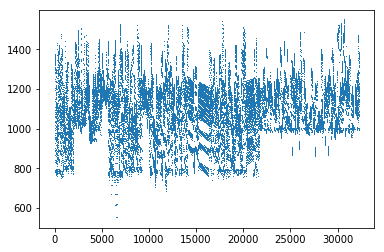

In [6]:
df['Specific density, kg/m<SUP>3</SUP>'].plot(ls='',marker=',')

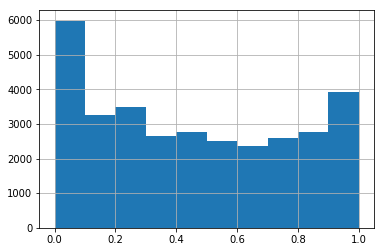

In [7]:
df['mol fraction salt'].hist()

In [51]:
df.columns

Index(['name-anion', 'name-cation', 'name-solvent', 'Temperature, K',
       'Pressure, kPa', 'mol fraction salt',
       'Specific density, kg/m<SUP>3</SUP>'],
      dtype='object')

In [55]:
col

'Pressure, kPa'

In [64]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
from matplotlib import colors
from itertools import cycle

def my_colors():
    tab = cycle(colors.TABLEAU_COLORS)
    return tab

In [ ]:
#combine names, group together, plot 

In [78]:
df['name-solvent'].unique()

array(['propan-2-ol', 'butan-1-ol', 'N-methylpyrrolidone',
       '2-pyrrolidinone', 'pyridine', 'cyclohexanone', 'cyclopentanone',
       'aniline', '2-methylaniline', 'N-methylaniline', 'nitromethane',
       'acetonitrile', 'octan-1-ol', 'propan-1-ol', '1,2-ethanediol',
       'glycerol', 'methanol', 'ethanol', 'water'], dtype=object)

In [79]:
df.columns

Index(['name-anion', 'name-cation', 'name-solvent', 'Temperature, K',
       'Pressure, kPa', 'mol fraction salt',
       'Specific density, kg/m<SUP>3</SUP>'],
      dtype='object')

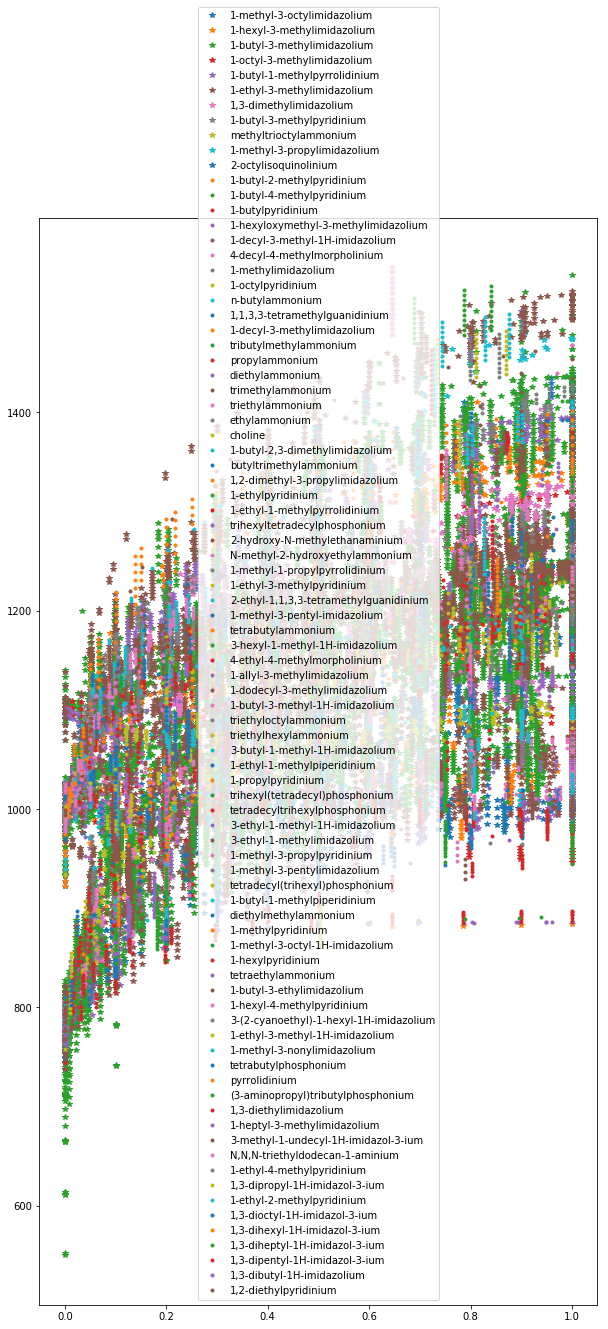

In [97]:
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(111)
for index, solvent in enumerate(df[df.columns[1]].unique()):
    if index > 10:
        mk = '.'
    else:
        mk = '*'
    dff = df.loc[df[df.columns[1]] == solvent]
    ax.plot(dff['mol fraction salt'], dff['Specific density, kg/m<SUP>3</SUP>'], ls='', marker=mk, label=solvent)
ax.legend()

In [ ]:
system

Text(0, 0.5, 'Specific Density $(kg/m^3)$')

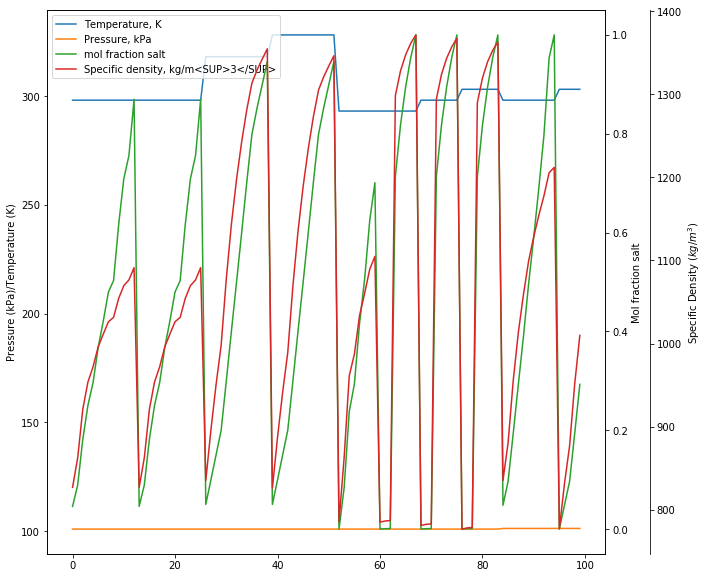

In [73]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.08))
make_patch_spines_invisible(ax3)
ax3.spines["right"].set_visible(True)
ax = [ax1, ax1, ax2, ax3]
cols = df.columns[3:]
tab = my_colors()

for index, col in enumerate(cols):
    df.iloc[:100][col].plot(ax=ax[index],c=next(tab))
#     df.iloc[:50][df.columns[6:]].plot(ax=ax2)
#     df.iloc[:50][df.columns[3:5]].plot(ax=ax3)
# ax2.legend(bbox_to_anchor=(1.11,1))
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
h3, l3 = ax3.get_legend_handles_labels()
ax1.legend(h1+h2+h3, l1+l2+l3, loc=2)
# ax1.set_title(col)
ax1.set_ylabel('Pressure (kPa)/Temperature (K)')
ax2.set_ylabel('Mol fraction salt')
ax3.set_ylabel('Specific Density $(kg/m^3)$')

In [4]:
df['system'] = df['smiles-cation'] + df['smiles-anion'] + df['smiles-solvent']

In [55]:
len(df['system'].unique())

446

In [22]:
import matplotlib.markers as mks

In [33]:
mks?

In [45]:
np.remainder(15,10)

5

<IPython.core.display.Javascript object>


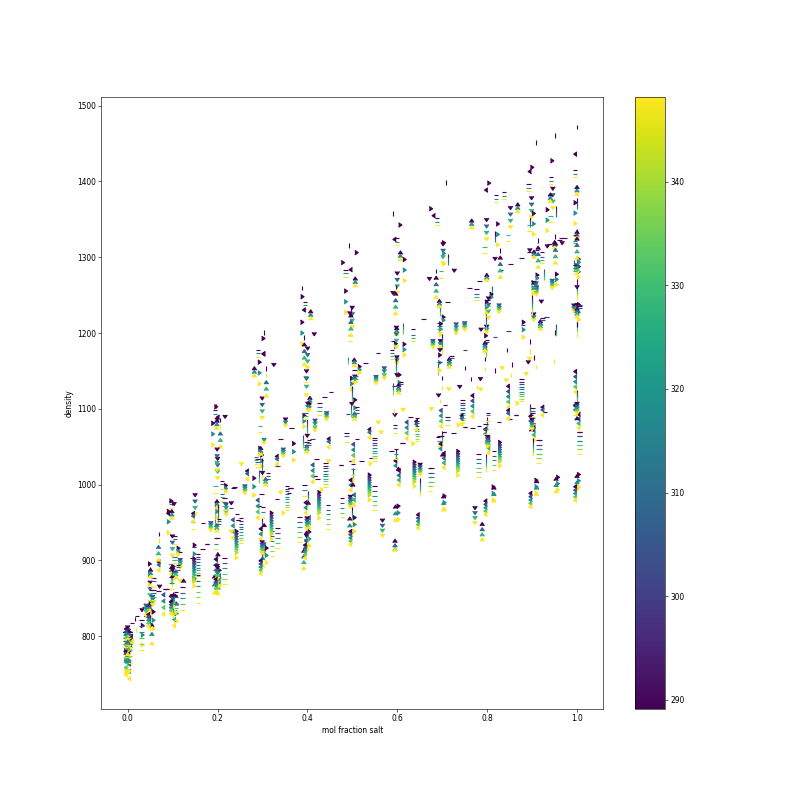

In [59]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
%matplotlib notebook
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
for i in range(50):
    dff = df.loc[df['system'] == df['system'].unique()[i]]
    xs = dff['mol fraction salt']
    ys = dff['Pressure, kPa']
    zs = dff['Specific density, kg/m<SUP>3</SUP>']
    cs = dff['Temperature, K']
    m = '.'
    ax.set_xlabel('mol fraction salt')
    ax.set_ylabel('density')
#     ax.set_zlabel('density')
    p = ax.scatter(xs, zs, c=cs, marker=np.remainder(i,12))
fig.colorbar(p)

<IPython.core.display.Javascript object>


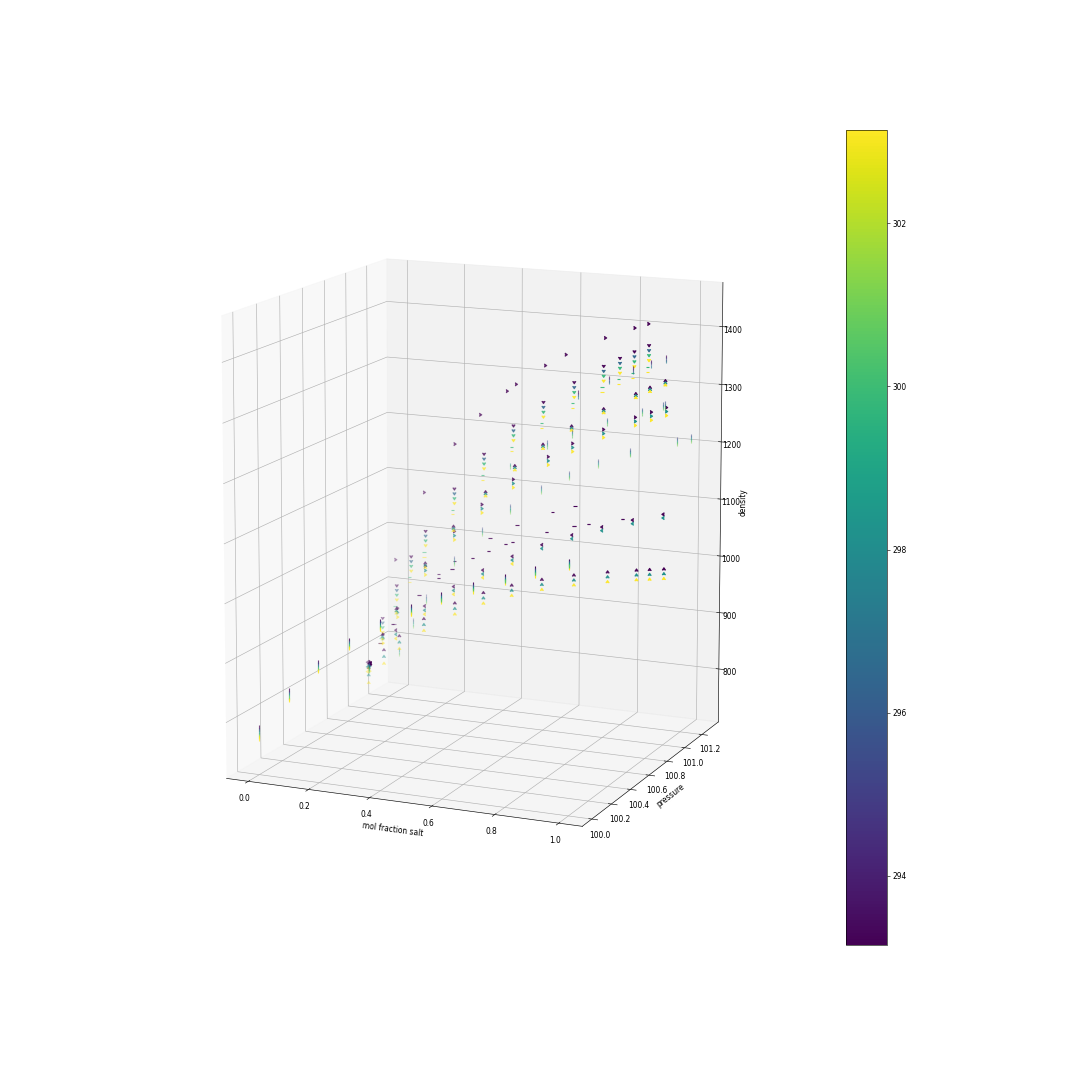

In [37]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
%matplotlib notebook
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
for i in range(11):
    dff = df.loc[df['system'] == df['system'].unique()[i]]
    xs = dff['mol fraction salt']
    ys = dff['Pressure, kPa']
    zs = dff['Specific density, kg/m<SUP>3</SUP>']
    cs = dff['Temperature, K']
    m = '.'
    ax.set_xlabel('mol fraction salt')
    ax.set_ylabel('pressure')
    ax.set_zlabel('density')
    p = ax.scatter(xs, ys, zs, c=cs, marker=i)
fig.colorbar(p)

In [60]:
df = pd.read_csv('../development/mixture_heat_capacity_premodel.csv')

In [63]:
df['system'] = df['smiles-cation'] + df['smiles-anion'] + df['smiles-solvent']

In [65]:
len(df['system'].unique())

58

In [61]:
df.columns

Index(['name-solvent', 'smiles-solvent', 'steiger-solvent',
       'Marsili Partial Charges-solvent', 'BalabanJ-solvent',
       'BertzCT-solvent', 'Ipc-solvent', 'HallKierAlpha-solvent',
       'Kappa1-solvent', 'Kappa2-solvent',
       ...
       'VSA_EState8-cation', 'VSA_EState9-cation', 'VSA_EState10-cation',
       'Topliss fragments-cation', 'solvent', 'salt', 'mol fraction salt',
       'Temperature, K', 'Pressure, kPa',
       'Heat capacity at constant pressure, J/K/mol'],
      dtype='object', length=294)

<IPython.core.display.Javascript object>


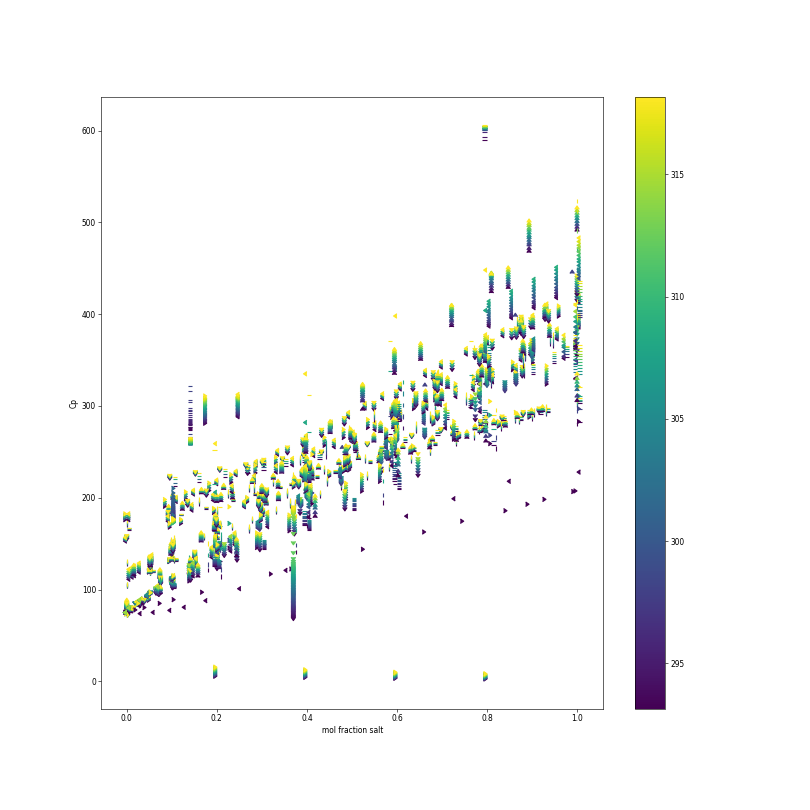

In [67]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
%matplotlib notebook
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
for i in range(58):
    dff = df.loc[df['system'] == df['system'].unique()[i]]
    xs = dff['mol fraction salt']
    ys = dff['Pressure, kPa']
    zs = dff['Heat capacity at constant pressure, J/K/mol']
    cs = dff['Temperature, K']
    m = '.'
    ax.set_xlabel('mol fraction salt')
    ax.set_ylabel('Cp')
#     ax.set_zlabel('density')
    p = ax.scatter(xs, zs, c=cs, marker=np.remainder(i,12))
fig.colorbar(p)